In [591]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import animation, cm
import seaborn as sns
import datetime
from scipy import stats
from scipy import optimize

from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

from typing import Union, List

"""
Own packages
"""
from codelib.dal.fred_yield_data import get_nominal_yield_data

from codelib.visualization.base import correlation_plot
from codelib.visualization.layout import DefaultStyle
DefaultStyle();

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exercises - Week 4

In this week we will look at a few exercises that 



## Problem 1: Parameter calibration in Nelson-Siegel-Svensson curve

__Note__: Exercise inspired somewhat by [M. Gilli, Stefan Große, E. Schumann (2010), "Calibrating the
Nelson–Siegel–Svensson model
"](https://comisef.eu/files/wps031.pdf)


[FRED](https://www.federalreserve.gov/data/nominal-yield-curve.htm) provides nominal yield curve data interpolated using the Nelson-Siegel-Svensson specificiation. It is assumed that the instantaneous forward rates are given by 

$$
f_t^T = \beta_0 + \beta_1 \exp \left(\frac{-(T-t)}{\tau_1}\right) + \beta_2 \frac{T-t}{\tau_1}\exp \left(\frac{-(T-t)}{\tau_1}\right) +  \beta_3 \frac{T-t}{\tau_2}\exp \left(\frac{-(T-t)}{\tau_2}\right)
$$

where $T-t$ is the time to maturity or tenor. The zero-coupon yield is then given by

$$
y_t^T = \frac{1}{T-t} \intop_t^T f_t^u du =  \beta_0 + \beta_1 \frac{1 - \exp\left(-\frac{T-t}{\tau_1} \right)}{\frac{T-t}{\tau_1}} + \beta_2 \left[ \frac{1 - \exp\left(-\frac{T-t}{\tau_1} \right)}{\frac{T-t}{\tau_1}}  - \exp\left(-\frac{T-t}{\tau_1} \right)\right] + \beta_3 \left[ \frac{1 - \exp\left(-\frac{T-t}{\tau_2} \right)}{\frac{T-t}{\tau_2}}  - \exp\left(-\frac{T-t}{\tau_2} \right)\right]
$$


__Question 1__

Define two Python functions `calculate_slope` and `calculate_curve`  as respectively

$$
\begin{align}
f_{slope}(T-t, \tau) &= \frac{1 - \exp\left(-\frac{T-t}{\tau} \right)}{\frac{T-t}{\tau}} \\
f_{curvature}(T-t, \tau) &= \left[ \frac{1 - \exp\left(-\frac{T-t}{\tau} \right)}{\frac{T-t}{\tau}}  - \exp\left(-\frac{T-t}{\tau} \right)\right]
\end{align}
$$

For $\tau = \tau_1$ from the FRED data set (use the date '2021-03-01') plot the level factor (just return one), the slope factor and the curvature factor for $T-t \in [0.001, 20.0]$. 

We should be able to see that the short rate is only governed by the first two factors (multiplied with the relevant $\beta$ coefficient). Other zero yields will be effected by the level factor and to some extent by the slope and the (two) curvature factors. 

__Question 2__

Define a function returning the zero yield for a given tenor. Plot the zero yields obtained using the function and the parameters for the date '2021-03-01' and the corresponding zero yields from the FRED data set. 

__Question 3__

We assume for a moment that we only observe the zero coupon yields for the FRED data set (or we have forgotten the specific parameter values).  We therefore want to calibrate the parameters. A natural approach would be to use [non-linear least squares](https://en.wikipedia.org/wiki/Non-linear_least_squares). To that end we define the quadratic objective function which we want to minimize

$$
g(\mathbf{y}; \theta) = \sum_{i=1}^n (y_i^{obs} - y_i^{model}(\theta))^2
$$
where $\theta = (\beta_0, \beta_1, \beta_2, \beta_3, \tau_1, \tau_2)^\top$. 

Define the quadratic objective function in Python and try to optimize it multiple times (e.g. 500) using `scipy.optimize.minimize`. Starting values can be selected randomly from the intervals $\beta_0 \in [0.0, 15.0]$, $\beta_1 \in [-15.0, 30.0]$, $\beta_2\in [-30.0, 30.0]$, $\beta_3\in [-30.0, 30.0]$, $\tau_1 \in (0.0, 30.0]$ and $\tau_2 \in (0.0, 30.0]$. Plot histogram of the obtained estimates. 

It should be obvious that we will not converge to the true solution for all starting values!

__Question 4__

The problems with the optimization above is related to the objective function not being convex and exhibiting several local minima and the so-called [collinearity](https://en.wikipedia.org/wiki/Multicollinearity) problem. 

For given values of $\tau_1$ and $\tau_2$, then the minimization problem reduces to a ordinary least squares problem. Thus, defining the regressor matrix 

$$
\mathbf{X} = \begin{bmatrix} 1 & \frac{1 - \exp\left(-\frac{T_1-t}{\tau_1} \right)}{\frac{T_1-t}{\tau_1}} & \left[ \frac{1 - \exp\left(-\frac{T_1-t}{\tau_1} \right)}{\frac{T_1-t}{\tau_1}}  - \exp\left(-\frac{T_1-t}{\tau_1} \right)\right] & \left[ \frac{1 - \exp\left(-\frac{T_1-t}{\tau_2} \right)}{\frac{T_1-t}{\tau_2}}  - \exp\left(-\frac{T_1-t}{\tau_2} \right)\right] \\
\vdots & \vdots & \vdots & \vdots  \\
1 & \frac{1 - \exp\left(-\frac{T_n-t}{\tau_1} \right)}{\frac{T_n-t}{\tau_1}} & \left[ \frac{1 - \exp\left(-\frac{T_n-t}{\tau_1} \right)}{\frac{T_n-t}{\tau_1}}  - \exp\left(-\frac{T_n-t}{\tau_1} \right)\right] & \left[ \frac{1 - \exp\left(-\frac{T_n-t}{\tau_2} \right)}{\frac{T_1-t}{\tau_2}}  - \exp\left(-\frac{T_n-t}{\tau_2} \right)\right] 
\end{bmatrix}
$$

leads to the OLS estimates 

$$
 (\hat{\beta}_0, \hat{\beta}_1, \hat{\beta}_2, \hat{\beta}_3)^\top = (\mathbf{X}^\top\mathbf{X})^{-1}\mathbf{X}^\top\mathbf{y}
$$

As we have seen in previous exercises, in the case of highly correlated regressors $ (\mathbf{X}^\top\mathbf{X})^{-1}$ may or may not have an inverse. If it has, it will likely be "ill-conditioned" such _"that a given computer algorithm may or may not be able to compute an approximate inverse, and if it does so the resulting computed inverse may be highly sensitive to slight variations in the data (due to magnified effects of either rounding error or slight variations in the sampled data points) and so may be very inaccurate or very sample-dependent"_ ([Wikipedia](https://en.wikipedia.org/wiki/Multicollinearity)).

This will also lead to failure of many optimizers. One obvious case that cannot work is $\tau_1 = \tau_2$ since we will have two perfectly correlated regressors. 

1. For $\tau_1=2.0$ and $\tau_2 \in [2.0, 30.0]$ plot the correlation between the first and second curvature factor. 


2. For the true values of $\tau_1$ and $\tau_2$ estimate the other parameters using OLS. 

__Question 5__

The insight from question 4, have lead many to grid seach over $\tau_1$ and $\tau$ and estimate the other parameters using OLS. The final estimate is then the values that gives the lowest value of the objective function. 

Use `scipy.optimize.brute` to implement the grid search. 


__Question 6__

As an alternative, one could also try to directly use a global optimizer. Try to use e.g. `scipy.optimize.sgho` to solve the optimization problem directly on NLS objective function. 



### Solution 

__Question 1__

In [592]:
# get data frame with Nelson-Siegel-Svensson parameters
all_nss_parameters = get_nominal_yield_data(output_type='parameters')
nss_parameters = all_nss_parameters.loc['2021-03-01']

# define functions 
def calculate_slope(time_to_maturity: Union[float, np.ndarray], tau: float): 
    
    return (1 - np.exp(-time_to_maturity / tau)) / (time_to_maturity / tau)

def calculate_curvature(time_to_maturity: Union[float, np.ndarray], tau: float): 
    
    return (1 - np.exp(-time_to_maturity / tau)) / (time_to_maturity / tau) - np.exp(-(time_to_maturity / tau))

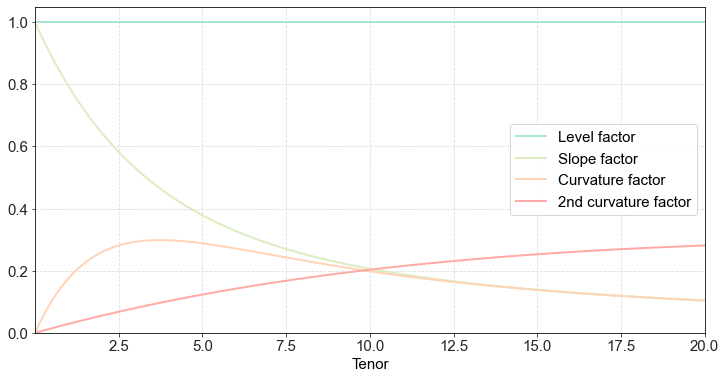

In [593]:
time_to_maturities = np.linspace(0.0001, 20.0, 1000)
tau1 = nss_parameters['TAU1']
tau2 = nss_parameters['TAU2']

level_factors = np.ones_like(time_to_maturities)
slope_factors = calculate_slope(time_to_maturities, tau1)
curvature_factors = calculate_curvature(time_to_maturities, tau1)
second_curvature_factors = calculate_curvature(time_to_maturities, tau2)

"""
Plotting 
"""

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time_to_maturities, level_factors, label="Level factor")
ax.plot(time_to_maturities, slope_factors, label="Slope factor")
ax.plot(time_to_maturities, curvature_factors, label="Curvature factor")
ax.plot(time_to_maturities, second_curvature_factors, label="2nd curvature factor")
ax.set_xlabel('Tenor')
ax.set_ylim([0.0, 1.05])
ax.legend();

__Question 2__


In [594]:
def calculate_nss_zero_yields(time_to_maturity: Union[float, np.ndarray], params: Union[np.ndarray, List]): 
    
    beta0 = params[0]
    beta1 = params[1]
    beta2 = params[2]
    beta3 = params[3]
    tau1 = params[4]
    tau2 = params[5]
    
    s = calculate_slope(time_to_maturity, tau1)
    c1 = calculate_curvature(time_to_maturity, tau1)
    c2 = calculate_curvature(time_to_maturity, tau2)
        
    return beta0 + beta1 * s + beta2 * c1 + beta3 * c2

In [595]:
# get data frame with Nelson-Siegel-Svensson parameters
all_nss_yields = get_nominal_yield_data(output_type='zero_yields')
nss_yields = all_nss_yields.loc['2021-03-01'].values
nss_tenors = np.arange(1.0, 31.0, 1.0)

# calculate yields
nss_yields_calc = calculate_nss_zero_yields(nss_tenors, nss_parameters.values)

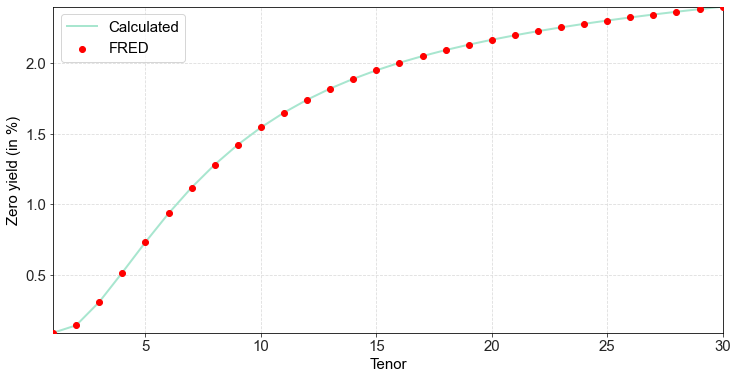

In [596]:
"""
Plotting 
"""

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(nss_tenors, nss_yields, label="FRED", color="red", zorder=3)
ax.plot(nss_tenors, nss_yields_calc, label="Calculated")
ax.set_xlabel('Tenor')
ax.set_ylabel('Zero yield (in %)')
ax.legend();

__Question 3__



In [597]:
# quadratic objective function 
def quad_objective(params: np.ndarray, tenors: np.ndarray, observed_yields: np.ndarray): 
    
    model_yields = calculate_nss_zero_yields(tenors, params)
    
    return np.sum(np.square(observed_yields - model_yields))

In [598]:
# evaluated at True parameters
quad_objective(nss_parameters.values, nss_tenors, nss_yields)

2.6404764813101768e-08

In [599]:
# true parameter values
nss_parameters

BETA0     3.319355
BETA1    -3.044078
BETA2    -4.408990
BETA3    -1.352546
TAU1      2.079503
TAU2     16.663662
Name: 2021-03-01 00:00:00, dtype: float64

In [600]:
bounds = ((-np.inf, np.inf), (-np.inf, np.inf), (-np.inf, np.inf), (-np.inf, np.inf),
          (0.001, np.inf), (0.001, np.inf))

bounds = ((0.0, 15.0), (-15.0, 30.0), (-30.0, 30.0), (-30.0, 30.0),
          (0.001, 30.0), (0.001, 30.0))

# guessing on starting values - try som different
num_random = 500
beta0_vals = np.random.uniform(low=0, high=15.0, size=num_random)
beta1_vals = np.random.uniform(low=-15.0, high=30.0, size=num_random)
beta2_vals = np.random.uniform(low=-30.0, high=30.0, size=num_random)
beta3_vals = np.random.uniform(low=-30.0, high=30.0, size=num_random)
tau1_vals = np.random.uniform(low=0.01, high=30.0, size=num_random)
tau2_vals = np.random.uniform(low=0.01, high=30.0, size=num_random)

random_params = np.array((beta0_vals, beta1_vals, beta2_vals, beta3_vals, tau1_vals, tau2_vals))

est_params = list()
for i in range(num_random): 
    res = optimize.minimize(quad_objective, args=(nss_tenors, nss_yields), x0=random_params[:, i], bounds=bounds)
    
    est_params.append(res.x)
    
est_params = np.array(est_params)

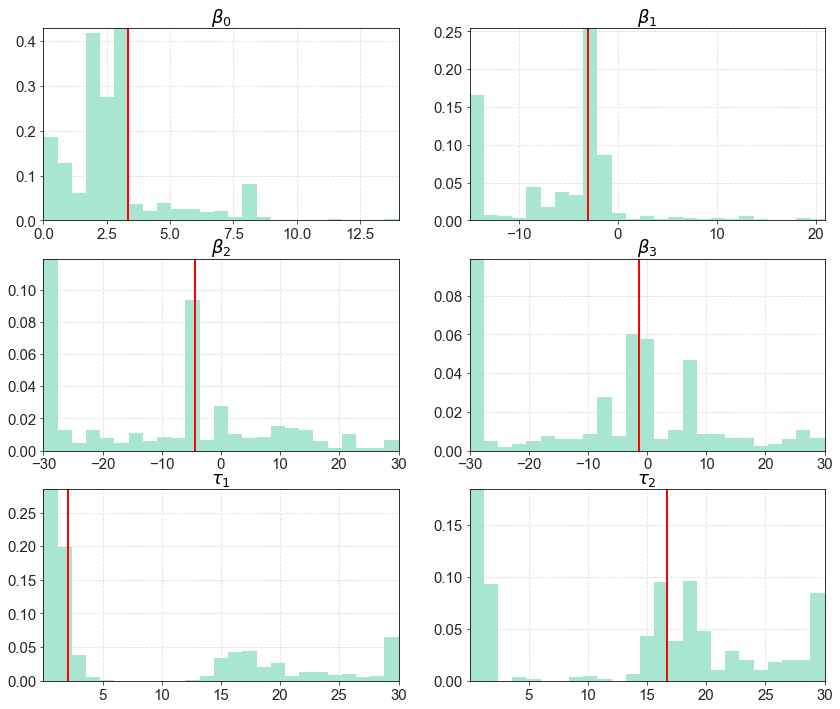

In [601]:
plot_names = ['$\\beta_0$', '$\\beta_1$', '$\\beta_2$', '$\\beta_3$', '$\\tau_1$', '$\\tau_2$']
fig, ax = plt.subplots(3, 2, figsize=(14, 12))
ax = ax.flatten()

for i in range(6): 
    
    ax[i].hist(est_params[:, i], bins=25, density=True)
    ax[i].set_title(plot_names[i])
    ax[i].axvline(x=nss_parameters.values[i], color="red")

__Question 4__

In [602]:
tau2_to_use = np.linspace(2.0, 30.0, 1000)
first_curvature_factor = calculate_curvature(nss_tenors, 2.0)

correlations = np.array([np.corrcoef(first_curvature_factor, calculate_curvature(nss_tenors, t))[0, 1] for t in tau2_to_use])

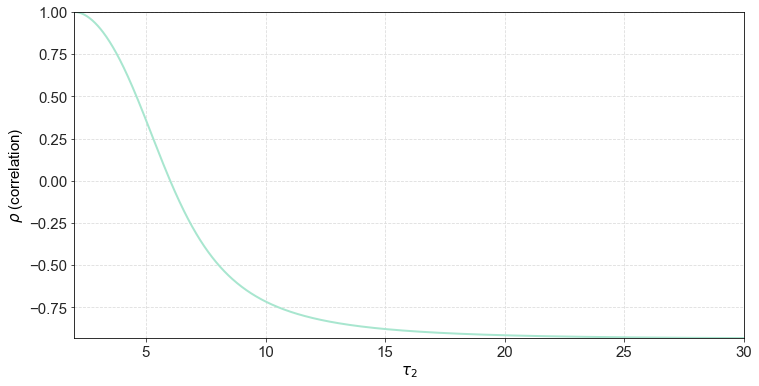

In [603]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(tau2_to_use, correlations)
ax.set_xlabel('$\\tau_2$')
ax.set_ylabel('$\\rho$ (correlation)'); 

In [604]:
nss_parameters

BETA0     3.319355
BETA1    -3.044078
BETA2    -4.408990
BETA3    -1.352546
TAU1      2.079503
TAU2     16.663662
Name: 2021-03-01 00:00:00, dtype: float64

In [605]:
"""
OLS estimation 
"""

X = np.c_[np.ones_like(nss_tenors),
          calculate_slope(nss_tenors, nss_parameters['TAU1']), 
          calculate_curvature(nss_tenors, nss_parameters['TAU1']),
          calculate_curvature(nss_tenors, nss_parameters['TAU2'])]

est_params = np.linalg.lstsq(X, nss_yields, rcond=None)
est_params

(array([ 3.31867029, -3.043471  , -4.40824409, -1.3506067 ]),
 array([2.38190083e-08]),
 4,
 array([5.79574361, 1.1021166 , 0.26851008, 0.01848762]))

In [606]:
"""
OLS with slightly different taus -> somewhat different estimates, very sensitive
"""

X = np.c_[np.ones_like(nss_tenors),
          calculate_slope(nss_tenors, nss_parameters['TAU1'] + 0.1), 
          calculate_curvature(nss_tenors, nss_parameters['TAU1'] + 0.1),
          calculate_curvature(nss_tenors, nss_parameters['TAU2'] + 0.1)]

est_params = np.linalg.lstsq(X, nss_yields, rcond=None)
est_params

(array([ 3.80883077, -3.56593857, -4.63267348, -2.6912822 ]),
 array([0.00045062]),
 4,
 array([5.80707937, 1.11062559, 0.27319808, 0.01673655]))

__Question 5__

In [607]:
def ols_nss(taus: np.ndarray,  tenors: np.ndarray, observed_yields: np.ndarray):   
    
    X = np.c_[np.ones_like(nss_tenors),
              calculate_slope(nss_tenors, tau1), 
              calculate_curvature(nss_tenors, tau1),
              calculate_curvature(nss_tenors, tau2)]

    est_params = np.linalg.lstsq(X, nss_yields, rcond=None)
    
    return est_params[0]


def ols_quad_objective(taus: np.ndarray,  tenors: np.ndarray, observed_yields: np.ndarray): 
    
    tau1 = taus[0]
    tau2 = taus[1]
    
    X = np.c_[np.ones_like(nss_tenors),
              calculate_slope(nss_tenors, tau1), 
              calculate_curvature(nss_tenors, tau1),
              calculate_curvature(nss_tenors, tau2)]

    est_params = ols_nss(taus,  tenors, observed_yields)
    
    new_params = np.r_[est_params, taus]
    
    return quad_objective(new_params, tenors, observed_yields)

In [608]:
res = optimize.brute(ols_quad_objective, (slice(0.001, 5.0), slice(5.0, 30.0)), args=(nss_tenors, nss_yields), Ns=99999)
est_params = np.r_[ols_nss(res,  nss_tenors, nss_yields), res]
est_params

array([ 3.31867029, -3.043471  , -4.40824409, -1.3506067 ,  2.07950913,
       16.66400178])

In [609]:
quad_objective(est_params, nss_tenors, nss_yields)

2.3810588580051585e-08

__Question 6__

In [610]:
bounds = ((0.0, 15.0), (-15.0, 30.0), (-30.0, 30.0), (-30.0, 30.0),
          (0.001, 5.0), (2.0, 30.0))
optimize.dual_annealing(quad_objective,  args=(nss_tenors, nss_yields), bounds=bounds, maxiter=999)

     fun: 0.00018293909585860016
 message: ['Maximum number of iteration reached']
    nfev: 12318
    nhev: 0
     nit: 999
    njev: 47
  status: 0
 success: True
       x: array([ 2.68788413, -2.38365213, -4.03072437,  0.42676073,  1.93358672,
       26.18420022])

In [611]:
optimize.shgo(quad_objective, args=(nss_tenors, nss_yields),
              bounds=bounds,
              n=200,
              sampling_method='sobol')

     fun: 2.282709269131446e-08
    funl: array([2.28270927e-08])
 message: 'Optimization terminated successfully.'
    nfev: 860
     nit: 2
   nlfev: 460
   nlhev: 0
   nljev: 63
 success: True
       x: array([ 3.31991399, -3.04480333, -4.40885843, -1.35400462,  2.07985564,
       16.67006917])
      xl: array([[ 3.31991399, -3.04480333, -4.40885843, -1.35400462,  2.07985564,
        16.67006917]])

In [612]:
"""
Plot countour plot beta0 vs tau2
"""
test_params = np.array([2.05, -1.82, -2.03, 8.25, 0.87, 14.38])
plot_quad_obj_beta0_tau2 = lambda x : quad_objective(np.r_[x[0], nss_parameters.values[1:-1], x[1]],
                                                     nss_tenors, nss_yields)

beta0 = np.linspace(-5.0, 15, 999)
tau2 = np.linspace(0.0001, 30, 999)
beta0grid, tau2grid = np.meshgrid(beta0, tau2)
inputs = np.stack([beta0grid, tau2grid])
quad_values = np.apply_along_axis(plot_quad_obj_beta0_tau2, 0, inputs)

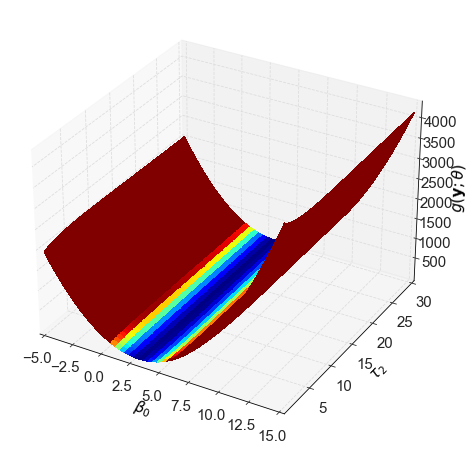

In [613]:
# Initialize figure 
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')

# Plot the surface
surf = ax.plot_surface(beta0grid, tau2grid, quad_values, cmap=cm.jet, linewidth=0, antialiased=False,
                       vmin=0.0, vmax=200)

ax.set_xlabel('$\\beta_0$')
ax.set_ylabel('$\\tau_2$')
ax.set_zlabel('$g(\mathbf{y}; \\theta)$');

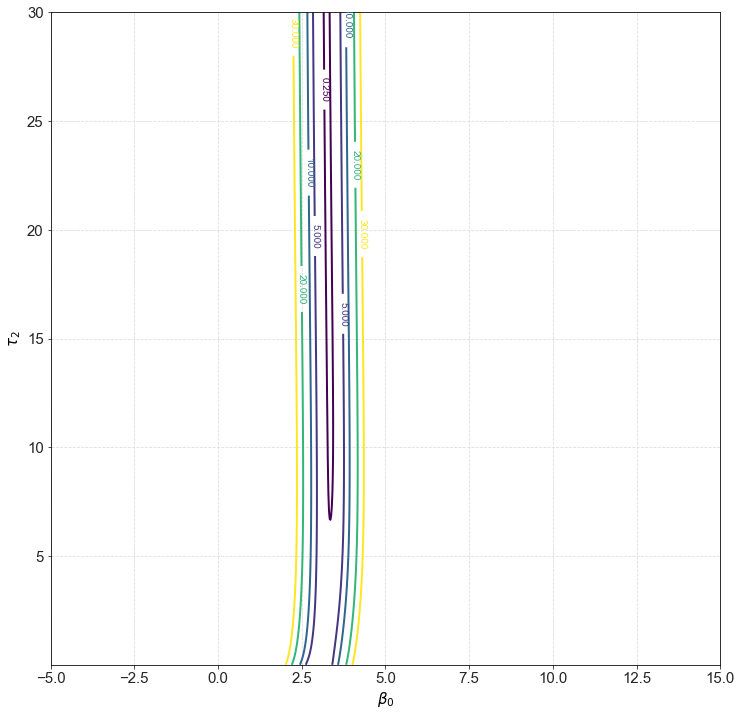

In [614]:
fig, ax = plt.subplots(figsize=(12, 12))
cs = ax.contour(beta0grid, tau2grid, quad_values, levels=[0.25, 5.0, 10.0, 20.0, 30])
ax.set_xlabel('$\\beta_0$')
ax.set_ylabel('$\\tau_2$')
ax.clabel(cs, inline=True, fontsize=10);

## Problem 2: Portfolio optimization with constraints

One way to cast the investor's one period portfolio optimization problem (in a Markowitz framework) is to minimize the portfolio variance $\text{Var}[R_p]$

$$
\underset{\mathbf{w}}{\text{arg min}} \text{Var}[R_p] = \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}
$$

subject to meeting the target return $p$

$$
\mathbf{w}^\top \boldsymbol{\mu} = p
$$

We also want the portfolio weights to sum to one and not allow for short-selling

$$
\mathbf{w}^\top \mathbf{1} = 1 \\
w_i \geq 0, \; i=1,2, ..., N
$$

__Question 1__

Obtain the equally weighted monthly return data for the five Fama-French industry portfolios ("5_Industry_Portfolios") using `pandas-datareader` since 1990-01-01. Calculate the expected monthly mean return and covariance matrix. 


__Question 2__

Solve the previously defined optimization problem using the estimates from question 1. Consider different target values $p \in [0.01, 0.013]$ (expected monthly return). 

__Question 3__

Plot the optimal allocation and the efficient frontier in two seperat figures. 

__Question 4__

Repeat the calculations in the two previous questions when allocation to a particular index is restricted to be no more than 25%. 


### Solution

__Question 1__

In [615]:
#get_available_datasets()

In [616]:
reader = FamaFrenchReader("12_Industry_Portfolios", start=datetime.datetime(1999, 1, 1))
industry_port = reader.read()

# print description
industry_port['DESCR']

'12 Industry Portfolios\n----------------------\n\nThis file was created by CMPT_IND_RETS using the 202106 CRSP database. It contains value- and equal-weighted returns for 12 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2021 Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Monthly (270 rows x 12 cols)\n  1 : Average Equal Weighted Returns -- Monthly (270 rows x 12 cols)\n  2 : Average Value Weighted Returns -- Annual (22 rows x 12 cols)\n  3 : Average Equal Weighted Returns -- Annual (22 rows x 12 cols)\n  4 : Number of Firms in Portfolios (270 rows x 12 cols)\n  5 : Average Firm Size (270 rows x 12 cols)\n  6 : Sum of BE / Sum of ME (22 rows x 12 cols)\n  7 : Value-Weighted Average of BE/ME (22 rows x 12 cols)'

In [617]:
# get equally weighted
ind_eq_weighted = industry_port[1] / 100

# get market cap weighted 
ind_mc_weighted = industry_port[0] / 100

# asset list
asset_list = ind_mc_weighted.columns

In [618]:
mu_est  = ind_eq_weighted.mean().values
cor_mat_est = ind_eq_weighted.corr().values
vol_est = ind_eq_weighted.std().values
cov_mat_est = np.outer(vol_est, vol_est)*cor_mat_est

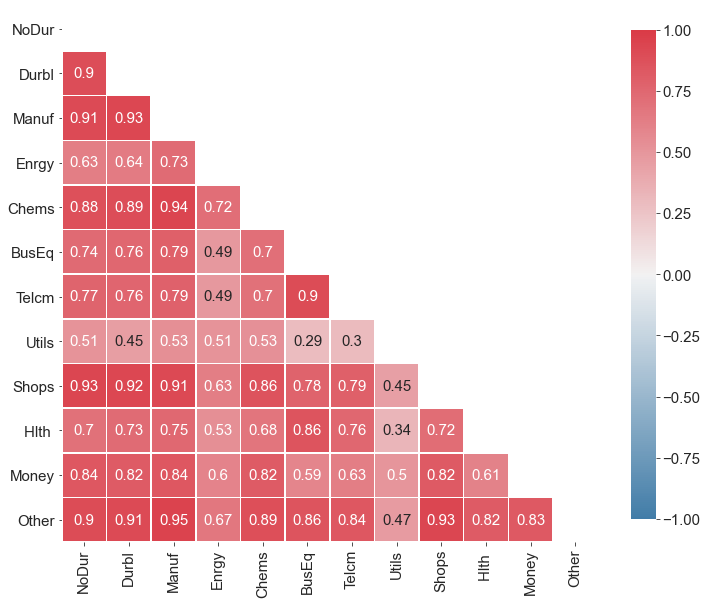

In [619]:
fig, ax = plt.subplots(figsize=(12, 12))
correlation_plot(cor_mat_est, names=asset_list, include_values=True, ax=ax)

__Question 2__

In [620]:
# define objective function 
def portfolio_variance(w: np.ndarray, cov_mat: np.ndarray): 
    return w @ cov_mat @ w

# define common constraints 
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0, #,
                   'jac' : lambda x: np.ones_like(x)}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x,
                 'jac' : lambda x: np.eye(len(x))}

# alternatively use 
bounds = [(0.0, 1.0)] * len(mu_est)

# define constraint 
target_cons = {'type': 'eq',
               'fun' : lambda x: x @ mu_est - 0.013,
               'jac' : lambda x: mu_est}

port_var_der = lambda w, cov_mat: 2 * w @ cov_mat


x0 = np.ones_like(mu_est) / len(mu_est)
res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat_est,),
                        method='SLSQP',
                        jac=port_var_der,
                        constraints=[sum_to_one_cons, no_short_cons,  target_cons],  # no_short_cons,
                        options={'ftol': 1e-9, 'disp': True}) #, bounds=bounds)

res

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0027586604402798053
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26


     fun: 0.0027586604402798053
     jac: array([0.00420825, 0.0064391 , 0.00567146, 0.00731191, 0.00507983,
       0.00771313, 0.00682984, 0.002395  , 0.00535535, 0.00799738,
       0.00334695, 0.00577699])
 message: 'Optimization terminated successfully'
    nfev: 26
     nit: 26
    njev: 26
  status: 0
 success: True
       x: array([ 5.01843634e-18, -1.64937162e-17,  1.38895192e-17, -1.39032647e-17,
       -1.64677726e-19,  2.22107821e-02, -6.13070599e-18,  4.41552744e-01,
       -1.04862354e-18,  5.36236474e-01, -1.93012286e-17,  5.75319543e-18])

In [621]:
"""
Loop over different target expected return 
"""

x0 = np.ones_like(mu_est) / len(mu_est)
port_weights = list()
mu_targets = np.arange(0.01, 0.0155, 0.00025)
for p in mu_targets:
    
    # define constraint 
    target_cons = {'type': 'eq',
               'fun' : lambda x: x @ mu_est - p,
               'jac' : lambda x: mu_est}
    
    res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat_est,),
                            method='SLSQP',
                            jac=port_var_der,
                            constraints=[sum_to_one_cons, target_cons],
                            options={'ftol': 1e-9, 'disp': False},bounds=bounds)
    
    port_weights.append(res.x)
    
port_weights = np.array(port_weights) * 100

In [622]:
#port_weights
#mu_targets

__Question 3__

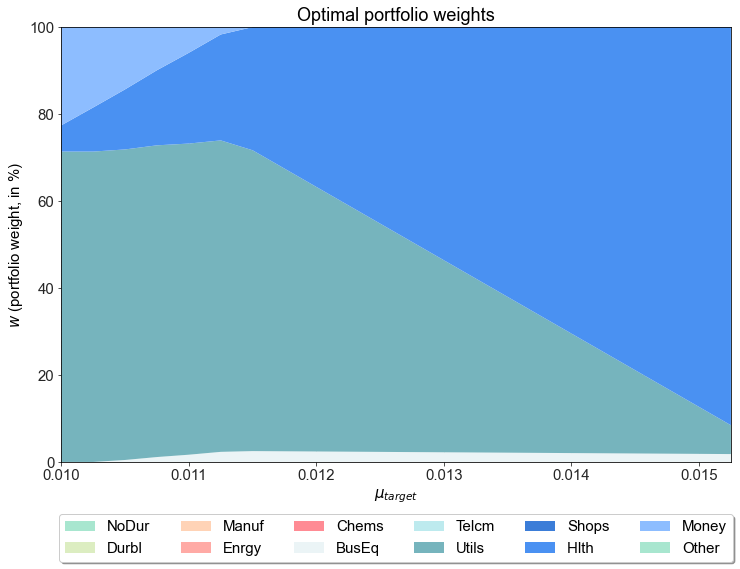

In [623]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.stackplot(mu_targets, port_weights.T, labels=asset_list);
ax.set_xlabel('$\\mu_{target}$')
ax.set_ylabel('$w$ (portfolio weight, in %)');
ax.set_title('Optimal portfolio weights');
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.175),
          fancybox=True, shadow=True, ncol=6);

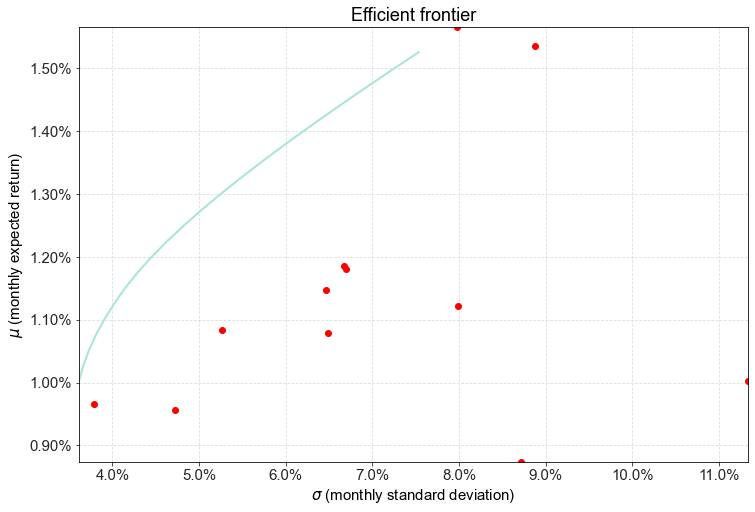

In [624]:
all_port_std = np.sqrt(np.apply_along_axis(portfolio_variance, 1, port_weights / 100, cov_mat_est))
all_mu = port_weights @ mu_est / 100.0


fig, ax = plt.subplots(figsize=(12,8))

ax.plot(all_port_std, all_mu, label='Efficient frontier')
ax.scatter(vol_est, mu_est, color="red", label="Individual assets"); 
ax.set_title('Efficient frontier'); 

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1)) 

ax.set_xlabel('$\\sigma$ (monthly standard deviation)')
ax.set_ylabel('$\\mu$ (monthly expected return)'); 

__Question  4__

In [625]:
bounds = [(0.0, 0.3)] * len(mu_est)
x0 = np.ones_like(mu_est) / len(mu_est)
port_weights = list()
mu_targets = np.arange(0.01, 0.0135, 0.0001)
for p in mu_targets:
    
    # define constraint 
    target_cons = {'type': 'eq',
               'fun' : lambda x: x @ mu_est - p,
               'jac' : lambda x: mu_est}
    
    res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat_est,),
                            method='SLSQP',
                            jac=port_var_der,
                            constraints=[sum_to_one_cons, target_cons],
                            options={'ftol': 1e-9, 'disp': False}, bounds=bounds)
    
    port_weights.append(res.x)
    
port_weights = np.array(port_weights) * 100

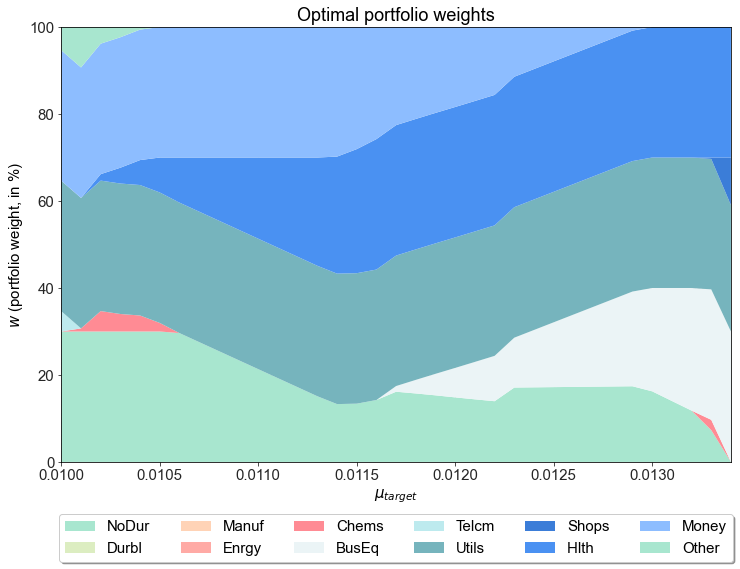

In [626]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.stackplot(mu_targets, port_weights.T, labels=asset_list);
ax.set_xlabel('$\\mu_{target}$')
ax.set_ylabel('$w$ (portfolio weight, in %)');
ax.set_title('Optimal portfolio weights');
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.175),
          fancybox=True, shadow=True, ncol=6);

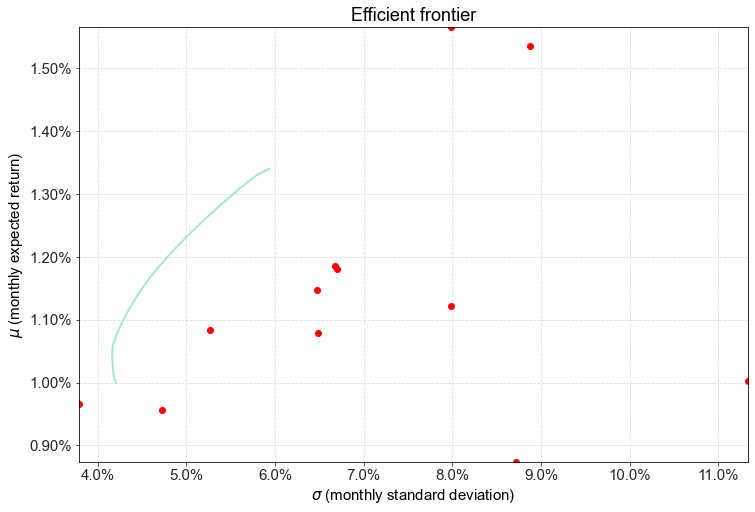

In [627]:
all_port_std = np.sqrt(np.apply_along_axis(portfolio_variance, 1, port_weights / 100, cov_mat_est))
all_mu = port_weights @ mu_est / 100.0


fig, ax = plt.subplots(figsize=(12,8))

ax.plot(all_port_std, all_mu, label='Efficient frontier')
ax.scatter(vol_est, mu_est, color="red", label="Individual assets"); 
ax.set_title('Efficient frontier'); 

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1)) 

ax.set_xlabel('$\\sigma$ (monthly standard deviation)')
ax.set_ylabel('$\\mu$ (monthly expected return)'); 

## Problem 3:  Minimizing CVaR (and VaR)

We now assume that an investor's one period portfolio optimization problem is to minimize the portfolio $\text{CVaR}_\beta[R_p]$

$$
\underset{\mathbf{w}}{\text{arg min }}  \text{CVaR}_\beta[R_p]
$$

subject to meeting the target return $p$

$$
\mathbf{w}^\top \boldsymbol{\mu} = p
$$

We also want the portfolio weights to sum to one and not allow for short-selling

$$
\mathbf{w}^\top \mathbf{1} = 1 \\
w_i \geq 0, \; i=1,2, ..., N
$$


__Question 1__

Implement the Mean-CVaR optimization problem using the same data set as in the previous problem for some target return. Let $\beta = 0.95$ (95% CVaR). 

__Question 2__

[Rockafeller and Uryasev (2000)](https://www.ise.ufl.edu/uryasev/files/2011/11/CVaR1_JOR.pdf) suggests an alternative way of solving the problem that ensures that the objective function is convex.  

Basically, the idea is that solving the minimization problem (when using the empirical distribution function)

$$
\underset{\mathbf{w}, \alpha}{\text{arg min }}  \alpha + \frac{1}{N (1 - \beta)} \sum_{i=1}^N \max [0, -\mathbf{w}^\top \mathbf{R}_i- \alpha]
$$

will result in the portfolio with lowest $\text{CVaR}_\beta[R_p]$ given the used constraints. $\alpha$ can be interpreted as the corresponding portfolio $\text{VaR}_\beta[R_p]$. 

Implement the described method with same constraints as in the previous question.

__Note__: It is a paper with more than 6000 citations, so it is worth a read! This method is the one typically implemented in portfolio optimization packages. 

__Question 3__

Using either of the two above approaches, consider different target values $p \in [0.01, 0.015]$ (expected monthly return). 

Plot the optimal allocations and the efficient frontier.  

### Solution

__Question 1__

In [628]:
reader = FamaFrenchReader("12_Industry_Portfolios", start=datetime.datetime(1999, 1, 1))
industry_port = reader.read()

# print description
industry_port['DESCR']

# get equally weighted
ind_eq_weighted = industry_port[1] / 100

# get market cap weighted 
ind_mc_weighted = industry_port[0] / 100

# asset list
asset_list = ind_mc_weighted.columns

In [629]:
mu_est  = ind_eq_weighted.mean().values
cor_mat_est = ind_eq_weighted.corr().values
vol_est = ind_eq_weighted.std().values
cov_mat_est = np.outer(vol_est, vol_est)*cor_mat_est

In [630]:
def calculate_cvar(w: np.ndarray, returns: np.ndarray, beta: float = 0.95): 
    
    # portfolio returns
    port_returns = returns @ w 
    
    # percentile
    perc = np.percentile(port_returns, (1 - beta)*100)
    
    # average in tail
    avg_tail = np.mean(port_returns[port_returns <= perc])
    
    return -avg_tail

In [631]:
# define common constraints 
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x}

# alternatively use 
bounds = [(0.0, 1.0)] * len(mu_est)

# define constraint 
target_cons = {'type': 'eq',
               'fun' : lambda x: x @ mu_est - 0.01}


x0 = np.ones_like(mu_est) / len(mu_est)
res = optimize.minimize(calculate_cvar, x0=x0, args=(ind_eq_weighted.values, 0.05),
                        method='SLSQP',
                        constraints=[sum_to_one_cons,  target_cons], 
                        options={'ftol': 1e-9, 'disp': True}, bounds=bounds)

res

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.006186722991660298
            Iterations: 37
            Function evaluations: 508
            Gradient evaluations: 37


     fun: -0.006186722991660298
     jac: array([-0.00681563, -0.00491992, -0.00650273, -0.00067773, -0.00652578,
       -0.01017695, -0.00404219, -0.0059082 , -0.00644648, -0.01066055,
       -0.00594883, -0.00553945])
 message: 'Optimization terminated successfully'
    nfev: 508
     nit: 37
    njev: 37
  status: 0
 success: True
       x: array([3.21898657e-02, 1.19479917e-17, 1.46306519e-18, 6.82693104e-18,
       8.29575068e-18, 3.14764332e-18, 0.00000000e+00, 8.33848016e-01,
       3.48343158e-18, 5.17577535e-02, 8.22043650e-02, 1.49147584e-18])

__Question 2__

In [632]:
def objective_function(x, returns, beta):

    w = x[0:-1]
    alpha = x[-1]

    port_returns = returns @ w

    # tail_scenarios
    tail_scenarios = np.maximum(-port_returns - alpha, 0.0)

    obj_func = alpha + np.sum(tail_scenarios) / (len(port_returns)*(1-beta))

    return obj_func


# define common constraints 
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x[:-1]) - 1.0}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x[:-1]}

# alternatively use 
bounds = [(0.0, 1.0)] * len(mu_est) + [(None, None)]

# define constraint 
target_cons = {'type': 'eq',
               'fun' : lambda x: x[:-1] @ mu_est - 0.01}


x0 = np.r_[np.ones_like(mu_est) / len(mu_est), 0.3]
res = optimize.minimize(objective_function, x0=x0, args=(ind_eq_weighted.values, 0.95),
                        method='SLSQP',
                        constraints=[sum_to_one_cons,  target_cons], 
                        options={'ftol': 1e-9, 'disp': True}, bounds=bounds)

res

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08143891867719386
            Iterations: 22
            Function evaluations: 339
            Gradient evaluations: 22


     fun: 0.08143891867719386
     jac: array([0.09458519, 0.13093481, 0.12354815, 0.17263704, 0.11322222,
       0.11442963, 0.12048889, 0.07905926, 0.10475556, 0.10208889,
       0.07528295, 0.11271111, 0.03703704])
 message: 'Optimization terminated successfully'
    nfev: 339
     nit: 22
    njev: 22
  status: 0
 success: True
       x: array([2.01422227e-18, 4.96016344e-17, 0.00000000e+00, 6.72897850e-17,
       0.00000000e+00, 0.00000000e+00, 4.43933461e-17, 7.85791064e-01,
       7.26018703e-19, 5.92235462e-02, 1.54985389e-01, 4.57675218e-18,
       4.96195110e-02])

In [633]:
# We get the same CVaR
calculate_cvar(res.x[:-1], ind_eq_weighted.values, 0.05)

-0.006175695654902097

In [634]:
res.x[-1]

0.049619511009631155

In [635]:
-np.percentile(ind_eq_weighted.values @ res.x[:-1], 5)

0.04940116380837528

__Question 3__

In [639]:
x0 = np.r_[np.ones_like(mu_est) / len(mu_est), 0.3]
port_weights = list()
mu_targets = np.arange(0.01, 0.0135, 0.0001)
for p in mu_targets:
    
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: x[:-1] @ mu_est - p}
    
    res = optimize.minimize(objective_function, x0=x0, args=(ind_eq_weighted.values, 0.95),
                        method='SLSQP',
                        constraints=[sum_to_one_cons,  target_cons], 
                        options={'ftol': 1e-9, 'disp': False}, bounds=bounds)
    
    port_weights.append(res.x[:-1])
    
port_weights = np.array(port_weights)

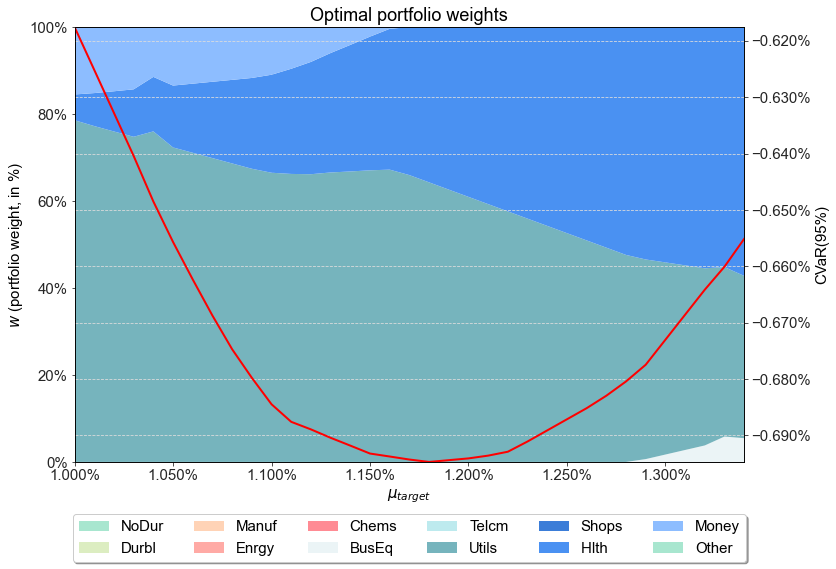

In [637]:
"""
Plotting
"""

fig, ax = plt.subplots(figsize=(12, 8))

ax.stackplot(mu_targets, port_weights.T, labels=asset_list);
ax.set_xlabel('$\\mu_{target}$')
ax.set_ylabel('$w$ (portfolio weight, in %)');
ax.set_title('Optimal portfolio weights');
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.175),
          fancybox=True, shadow=True, ncol=6);
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 


all_port_cvar = np.apply_along_axis(calculate_cvar, 1, port_weights , ind_eq_weighted.values, 0.05)
all_mu = port_weights @ mu_est 

ax_new = ax.twinx()
ax_new.plot(all_mu, all_port_cvar,  color="red")

ax_new.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 
ax_new.xaxis.set_major_formatter(mtick.PercentFormatter(1)) 
ax_new.set_ylabel('CVaR(95%)');

# References


## Articles

[Svensson (1994)](https://www.nber.org/papers/w4871)

[Rockafeller and Uryasev (2000)](https://www.ise.ufl.edu/uryasev/files/2011/11/CVaR1_JOR.pdf)

## Books